예제 2-1 CIFAR-10 데이터 준비 및 전처리

In [2]:
import numpy as np
from tensorflow.keras import datasets, utils
# from tensorflow import datasets, utils 구버전 명령문

# CIFAR-10 dataset load
# x_train, x_test는 각각 [50000,32,32,3], [10000,32,32,3] 크기의 np배열로 각 이미지 클래스에 대해 0~9 범위 정수 레이블로 설정
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

NUM_CLASSES = 10

# pixel ch 값이 0과 1사이가 되도록 이미지 스케일 조정
x_train = x_train.astype('float32') /255.0
x_test = x_test.astype('float32') / 255.0

# 레이블 원핫 인코딩. y_train, y_test 크기를 각각 [50000, 10], [10000, 10] 으로 설정
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [3]:
# 인덱스가 54인 이미지 (12,13) 위치에 있는 픽셀 R(0), G(1), B(2) 의 값 확인
print(x_train[54,12,13,0])
print(x_train[54,12,13,1])
print(x_train[54,12,13,2])

0.2627451
0.36862746
0.16470589


모델 생성

In [4]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Flatten(input_shape=(32,32,3)),
#     layers.Dense(200, activation = 'relu'),
#     layers.Dense(150, activation = 'relu'),
#     layers.Dense(10, activation = 'relu'),
# ])

In [11]:
# 함수형 API를 사용해 동일한 MLP 생성.
# 이러한 모델을 구성할 때에는 Sequential 클래스보다는 유연한 함수형 API를 사용하는것이 좋음.
# 신경망의 구조가 복잡해짐에 따라 장기적으로 나은 선택이 된다. 함수형 API를 사용하면 심층 신경망의 설계를 자유롭게 할 수 있음.
from tensorflow.keras import layers, models
input_layer = layers.Input((32, 32, 3))

x = layers.Flatten()(input_layer)
x = layers.Dense(200, activation="relu")(x)
x = layers.Dense(150, activation="relu")(x)

output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               614600    
                                                                 
 dense_4 (Dense)             (None, 150)               30150     
                                                                 
 dense_5 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646260 (2.47 MB)
Trainable params: 646260 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Input 층의 크기는 x_train의 크기와 맞아야 하고, Dense 출력 층의 크기는 y_train의 크기와 일치해야 한다. keras는 첫번째 차원에 None을 사용해 아직 네트워크에 전달될 샘플의 개수를 모른다는 것을 표시한다.
실제로 샘플 개수를 지정할 필요가 없다. 네트워크에 하나의 샘플을 전달하거나, 임의값 샘플을 전달할수도 있다. 텐서 연산은 선형수학을 사용해 동시에 모든 샘플에 수행되기 때문. tensorflow는 이런 작업을 처리한다.
심층 신경망을 CPU 대신 GPU에서 훈련할 때 훈련 성능이 향상되는 이유중 하나. GPU는 tensor 곱셈에 최적화되어있는데, 이런 계산이 복잡한 그래픽 조작에도 필요하기 때문.
summary 메서드는 각 층에서 훈련될 파라미터(가중치)의 수도 알려준다. 모델이 너무 느리게 훈련된다면 summary 메서드를 확인 후 너무 많은 가중차기 있지는 않은지 확인할 것. parameter 값을 조정해 속도를 높일수 있다.

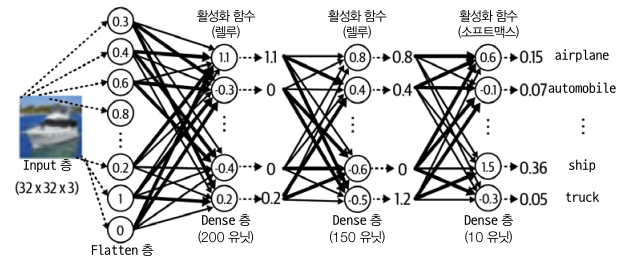
### 층
MLP 생성 시 세 종류(Input, Flatten, Dense)의 층을 사용했다.
Input 층은 네트워크의 시작점으로, 네트워크가 기대하는 입력 데이터 크기를 튜플로 알려주어야 한다. 배치 크기는 지정하지 않았으며 Input 층에 임의의 이미지 개수를 전달할 수 있기 때문에 배치 크기가 필요하지 않음.
다음 Flatten 층은 입력을 하나의 벡터로 펼친다. 결과 벡터의 길이는 3,072(32*32*3). 이렇게 하는 이유는 후의 Dense층이 다차원 배열이 아닌 평평한 입력을 기대하기 때문. 다른 종류의 층은 입력을 다차원 배열으로 사용해야 한다. 언제 Flatten 층을 사용하는지 이해하려면 층마다 필요한 입력과 출력의 크기를 알아야 한다.
Dense층은 기본적 신경망 구성 요소. 이 층에는 이전 층과 완전하게 연결되는 유닛이 있다. 즉, 이 층의 각 유닛은 이전 층의 모든 유닛과 연결된다. 연결마다 하나의(양수 또는 음수) 가중치가 동반된다. 유닛의 출력은 이전 층에서 받은 입력과 가중치를 곱해 더한 것임. 이후 비선형 활성화 함수를 통과해 다음 층으로 전달됨. 활성화 함수는 신경망이 복잡한 함수를 학습하는데 중요한 역할을 한다. 그렇지 않으면 입력을 선형적으로 조합한 값만 출력될 것임.
### 활성화 함수
활성화 함수의 종류가 많다. 대표적은 세 개의 활성화 함수는 렐루, 시그모이드, 소프트맥스.
#### 렐루
 활성화 함수는 입력이 음수이면 0이고, 그 외에는 입력과 동일한 값을 출력한다. 리키렐루 호할성화 함수는 한 가지만 빼고 렐루와 비슷하다. 렐루 활성화 함수는 입력이 0보다 작으면 0을 반환하지만 리키렐루 함수는 입력에 비례하는 작은 음수를 반환한다. 편향이 이미 큰 음수값이라 렐루 함수가 항상 0을 출력한다면 이 유닛은 아무것도 학습할 수 없기 때문. 이 경우 gradient가 0이 되어 어떤 오류도 이 유닛을 통해 전파되지 않는다. 리키렐루 활성화 함수는 gradient가 0이 되지 않도록 해 문제를 해결하기 위해 개발된 함수. 렐루 기반의 함수는 심층 신경망의 층을 안정적으로 훈련할 수 있는 믿을만한 함수 중 하나.
#### 시그모이드
활성화 함수는 층의 출력을 0에서 1사이로 조정하고 싶을 때 유용하다. 예로 출력 유닛이 하나인 이진 분류 문제나 샘플이 하나 이상의 클래스에 속할 수 있는 다중 레이블 분류 문제에서 사용한다. 아래 그림은 렐루, 리키렐루, 시그모이드 함수를 비교한 값.

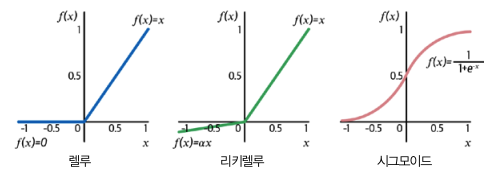
#### 소프트맥스
층의 전체 출력 합이 1이 되어야 할 때 사용. 예제에서 소프트맥스 함수를 사용해 마지막 층의 합이 1인 10개의 확률을 출력했다. 이 값을 이미지가 10개의 클래스에 속할 확률로 이해할 수 있다.

Dense 층의 일부로 정의된 렐루 활성화 함수<br>
x = layers.Flatten()(input_layer)

별도의 층으로 정의된 렐루 활성화 함수<br>
x = layers.Dense(200, activation="relu")(x)<br>
x = layers.Activation('relu')(x)

입력을 두개의 Dense층에 통과시킨다. 첫 층에는 유닛이 200개, 둘째 층에는 150개. 둘 모두 렐루 활성화 함수를 사용한다.

In [ ]:
test test